In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import unicodedata
import igviz as ig
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sys

sys.path.append('../src')
import utils

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

## Borders dataset 
Taken from: 
    https://github.com/geodatasource/country-borders

In [3]:
brd_df = pd.read_csv('../data/land_borders.CSV')
brd_df.head()

,country_code,country_name,country_border_code,country_border_name
0,AD,Andorra,FR,France
1,AD,Andorra,ES,Spain
2,AE,United Arab Emirates,OM,Oman
3,AE,United Arab Emirates,SA,Saudi Arabia
4,AF,Afghanistan,CN,China


In [4]:
# standardize
brd_df = brd_df.applymap(lambda s:s.lower() if type(s) == str else s)
#brd_df = brd_df.dropna()

In [5]:
# rename columns
brd_df.rename(columns={"country_name": "country",
                   "country_code": "country_code",
                   "country_border_name": "neighbor", 
                   "country_border_code": "neighbor_code"}, inplace = True)

In [6]:
brd_df.head()

,country_code,country,neighbor_code,neighbor
0,ad,andorra,fr,france
1,ad,andorra,es,spain
2,ae,united arab emirates,om,oman
3,ae,united arab emirates,sa,saudi arabia
4,af,afghanistan,cn,china


- Dataframe without neighbors

In [7]:
df_no_neighbors = brd_df[brd_df['neighbor'].isna()]
df_no_neighbors.head(3)

,country_code,country,neighbor_code,neighbor
10,ag,antigua and barbuda,NaN,NaN
11,ai,anguilla,NaN,NaN
24,aq,antarctica,NaN,NaN


- Dataframe with neighbors

In [8]:
brd_df = brd_df.dropna()

## Coordinates dataset  
Taken from: 
    https://gist.github.com/tadast/8827699#filecountries_codes_and_coordinates-csv

In [9]:
# http://techslides.com/list-of-countries-and-capitals#google_vignette
coord_df = pd.read_csv('../data/country-capitals.csv')

In [10]:
new_row = {'CountryName': 'French Guiana', 
           'CapitalName': 'Cayenne', 
           'CapitalLatitude':4.9372, 
           'CapitalLongitude':-52.326, 
           'CountryCode':'GF',
           'ContinentName': 'America'}
#append row to the dataframe
coord_df = coord_df.append(new_row, ignore_index=True)

In [11]:
# standardize
coord_df = coord_df.applymap(lambda s:s.lower() if type(s) == str else s)
## removes special characters
coord_df = coord_df.applymap(lambda s:unicodedata.normalize('NFD', s).encode('ascii', 'ignore').decode("utf-8") if type(s) == str else s)
coord_df.tail(3)

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName
242,british indian ocean territory,diego garcia,-7.3000,72.400,io,africa
243,macau,NaN,0.0000,0.000,mo,asia
244,french guiana,cayenne,4.9372,-52.326,gf,america


In [12]:
coord_df.rename(columns={"CountryName": "country",
                       "CapitalName": "capital",
                       "CountryCode": "country_code",
                       "CapitalLongitude": "longitude",
                       "CapitalLatitude": "latitude",
                       "ContinentName": "continent"}, 
                        inplace = True)

coord_df_filt = coord_df.copy()[['country_code','latitude', 'longitude', 'continent']]
coord_df_filt.dropna(inplace=True)
coord_df_filt.head(3)

,country_code,latitude,longitude,continent
1,gs,-54.283333,-36.500000,antarctica
2,tf,-49.350000,70.216667,antarctica
3,ps,31.766667,35.233333,asia


# Using average coordinates for a better visualization

In [13]:
## Other approach
coord_df_2 = pd.read_csv('../data/countries_codes_and_coordinates.csv')
coord_df_2.head()

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,Afghanistan,"""AF""","""AFG""","""4""","""33""","""65"""
1,Albania,"""AL""","""ALB""","""8""","""41""","""20"""
2,Algeria,"""DZ""","""DZA""","""12""","""28""","""3"""
3,American Samoa,"""AS""","""ASM""","""16""","""-14.3333""","""-170"""
4,Andorra,"""AD""","""AND""","""20""","""42.5""","""1.6"""


In [14]:
# Clean characters
coord_df_2[coord_df_2.columns] = coord_df_2[coord_df_2.columns].replace({'\"':''}, regex=True)
coord_df_2[coord_df_2.columns] = coord_df_2[coord_df_2.columns].replace({' ':''}, regex=True)

In [15]:
# rename columns
coord_df_2.rename(columns={"Country": "country",
                       "Alpha-2 code": "country_code",
                       "Latitude (average)": "latitude",
                       "Longitude (average)": "longitude"}, 
                        inplace = True)
coord_df_2 = coord_df_2[['country', 'country_code', 'latitude', 'longitude']]

In [16]:
num_list = ['latitude', 'longitude']
coord_df_2[num_list] = coord_df_2[num_list].apply(pd.to_numeric, errors='coerce')

In [17]:
# standardize
coord_df_2 = coord_df_2.applymap(lambda s:s.lower() if type(s) == str else s)

In [18]:
coord_df_filt2 = coord_df_2.copy()[['country_code','latitude', 'longitude']]
coord_df_filt2.dropna(inplace=True)
coord_df_filt2.head()

,country_code,latitude,longitude
0,af,33.0000,65.0
1,al,41.0000,20.0
2,dz,28.0000,3.0
3,as,-14.3333,-170.0
4,ad,42.5000,1.6


## Join dataframes

- Isolated Countries

In [19]:
full_df_iso = pd.merge(df_no_neighbors, coord_df_filt, on='country_code', how='inner')
full_df_iso.head(2)

,country_code,country,neighbor_code,neighbor,latitude,longitude,continent
0,ag,antigua and barbuda,NaN,NaN,17.116667,-61.85,north america
1,ai,anguilla,NaN,NaN,18.216667,-63.05,north america


- Other Countries

In [20]:
# First approach
full_df = pd.merge(brd_df, coord_df_filt, on='country_code', how='inner')
full_df.head(2)

,country_code,country,neighbor_code,neighbor,latitude,longitude,continent
0,ad,andorra,fr,france,42.5,1.516667,europe
1,ad,andorra,es,spain,42.5,1.516667,europe


In [21]:
# second approach
full_df2 = pd.merge(brd_df, coord_df_filt2, on='country_code', how='inner')
full_df2.head(2)

,country_code,country,neighbor_code,neighbor,latitude,longitude
0,ad,andorra,fr,france,42.5,1.6
1,ad,andorra,es,spain,42.5,1.6


## Create dictionary of coordinates

In [22]:
scale_factor = 25

- Coordinates for isolated countries

In [23]:
## isolated nodes

## Dictionary with positions
coords_iso = list(zip(full_df_iso['longitude'], full_df_iso['latitude']))
dic_coords_iso = {}
# create dictionary with positions
for pos, country_c in enumerate(full_df_iso['country_code']):
    dic_coords_iso[country_c] = coords_iso[pos]

## Lat and Lon
lat_iso = {}
lon_iso = {}
# create dictionary with positions
for pos, country_c in enumerate(full_df_iso['country_code']):
    lon_iso[country_c] = full_df_iso['longitude'][pos]*scale_factor
    lat_iso[country_c] = full_df_iso['latitude'][pos]*-1*scale_factor

- Coordinates of capitals

In [24]:
## to include as attribute
coords = list(zip(full_df['longitude'], full_df['latitude']))
dic_coords = {}
# create dictionary with positions
for pos, country_c in enumerate(full_df['country_code']):
    dic_coords[country_c] = coords[pos]
## https://stackoverflow.com/questions/42272710/networkx-how-to-assign-the-node-coordinates-as-attribute

- Coordinates (average)

In [25]:
## to include as attribute
coords2 = list(zip(full_df2['longitude'], full_df2['latitude']))
dic_coords2 = {}
# create dictionary with positions
for pos, country_c in enumerate(full_df2['country_code']):
    dic_coords2[country_c] = coords2[pos]
## https://stackoverflow.com/questions/42272710/networkx-how-to-assign-the-node-coordinates-as-attribute

In [26]:
## to include as attribute
lat = {}
lon = {}
# create dictionary with positions
for pos, country_c in enumerate(full_df2['country_code']):
    lon[country_c] = full_df2['longitude'][pos]*scale_factor
    lat[country_c] = full_df2['latitude'][pos]*-1*scale_factor
## https://stackoverflow.com/questions/42272710/networkx-how-to-assign-the-node-coordinates-as-attribute

## Graph

- Isolated countries

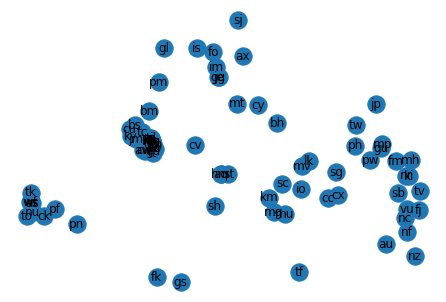

In [27]:
iso_countries = full_df_iso[['country_code']].set_index('country_code').to_dict('index')
G_iso = nx.Graph(iso_countries)
nx.set_node_attributes(G_iso, lon_iso, 'x')
nx.set_node_attributes(G_iso, lat_iso, 'y')

nx.draw(G_iso, pos=dic_coords_iso , with_labels=True)
plt.show()

- Other countries

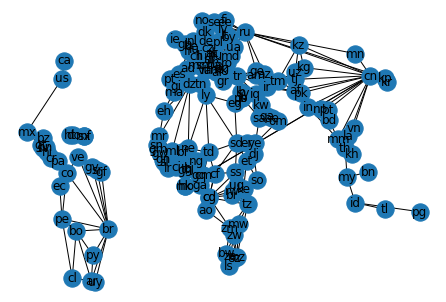

In [28]:
G = nx.Graph()
G = nx.from_pandas_edgelist(full_df, 'country_code', 'neighbor_code')
nx.set_node_attributes(G, dic_coords, 'coord')

nx.draw(G, pos=dic_coords , with_labels=True)
plt.show()

In [29]:
#{**dic_coords_iso, **dic_coords2}

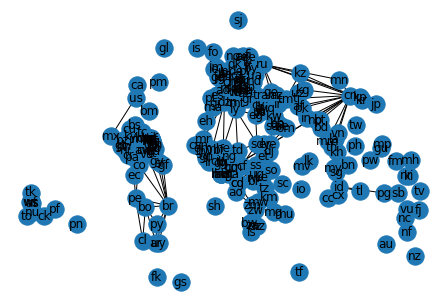

In [30]:
F = nx.compose(G,G_iso)
nx.draw(F, pos={**dic_coords_iso, **dic_coords}, with_labels=True)
plt.show()


## Adding flags as attribute

In [31]:
## Create dictionary of flags
dic_flags_iso = {}
for pos, country_c in enumerate(full_df_iso['country_code']):
    dic_flags_iso[country_c] = '../data/flags/' + country_c + '.png'

In [32]:
## Create dictionary of flags
dic_flags = {}
for pos, country_c in enumerate(full_df['country_code']):
    dic_flags[country_c] = '../data/flags/' + country_c + '.png'

In [33]:
nx.set_node_attributes(G, dic_flags, 'image')

## Number of neightbors


In [34]:
scale_factor_size = 15

In [35]:
# isolated
dic_weight_iso = {}
# create dictionary with positions
for country_c in full_df_iso['country_code']:
    dic_weight_iso[country_c] = scale_factor_size
    
nx.set_node_attributes(G_iso, dic_weight_iso, 'value')

In [36]:
weigths = full_df.set_index(["country_code", "neighbor"]).count(level="country_code")['country'].reset_index()

dic_weight = {}
# create dictionary with positions
for pos, country_c in enumerate(weigths['country_code']):
    dic_weight[country_c] = int(weigths['country'][pos])*scale_factor_size

In [37]:
w_lst = weigths['country'].to_numpy().tolist()

In [38]:
nx.set_node_attributes(G, dic_weight, 'value')

## Full graph

In [39]:
G_iso = nx.Graph(iso_countries)
nx.set_node_attributes(G_iso, dic_flags_iso, 'image')
nx.set_node_attributes(G_iso, lon_iso, 'x')
nx.set_node_attributes(G_iso, lat_iso, 'y')
nx.set_node_attributes(G_iso, dic_coords_iso, 'coord')
nx.set_node_attributes(G_iso, dic_weight_iso, 'size')


In [40]:
G = nx.Graph()
G = nx.from_pandas_edgelist(full_df, 'country_code', 'neighbor_code')
nx.set_node_attributes(G, dic_flags, 'image')
nx.set_node_attributes(G, lon, 'x')
nx.set_node_attributes(G, lat, 'y')
nx.set_node_attributes(G, dic_coords, 'coord')
nx.set_node_attributes(G, dic_weight, 'size')

# extrange nodes: investigate what is going on
G.remove_node('mf')
G.remove_node('sx')

In [41]:
## World graph
F = nx.compose(G, G_iso)

# Using [`pyvis`](https://pyvis.readthedocs.io/en/latest/index.html)

In [44]:
utils.draw_graph3(F, 
            notebook=True,
            output_filename='graph.html',
            show_buttons=False,
            only_physics_buttons=False,
            height='100%',
            width='100%',
            bgcolor='#000433',
            font_color=None,
            pyvis_options=None,
            p_type=True)